In [203]:
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
import pyccl as ccl
cosmo = ccl.Cosmology(Omega_c = 0.30711 - 0.048254, Omega_b = 0.048254, h = 0.677, sigma8 = 0.8288, n_s=0.96)

In [204]:
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_COUNT_class_cluster_abundance as cl_count
from CL_COUNT_Sij_FLacasa import Sij_FLacasa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


initialize the `ClusterAbundance` object

In [205]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25)*4*np.pi
clc.f_sky = clc.sky_area/4*np.pi

# Binned approach
Compute the 2D integral

## model

$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\log_{10}M_\beta}^{\log_{10}M_{\beta + 1}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}d\log_{10}M
$$

define mass & redshift binning

In [206]:
z_corner = np.linspace(0.25, 1.25, 51)
logm_corner = np.linspace(14, 14.8, 41)
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
Z_bin = binning(z_corner)
logMass_bin = binning(logm_corner)

In [207]:
#define redshift-mass grid
z_grid = np.linspace(0., 3, 900)
logm_grid = np.linspace(12,16, 900)

`simps`

### Abundance prediction

In [208]:
t0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance_simps = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))
time_simps = t1-t0

time (seconds) = 1.6642770767211914


In [209]:
Abundance_simps

array([[207.12351672, 194.78678605, 183.34982298, ...,  12.43629136,
         11.26114736,  10.17485378],
       [230.31413344, 216.47402895, 203.64879892, ...,  13.37459141,
         12.09358251,  10.91102061],
       [253.30654672, 237.94801029, 223.72189808, ...,  14.21768312,
         12.83731609,  11.56478281],
       ...,
       [311.16792703, 281.68103228, 255.20608502, ...,   1.95587131,
          1.60877759,   1.31708278],
       [300.05362334, 271.33006574, 245.5650689 , ...,   1.77060327,
          1.45247387,   1.18584902],
       [289.03890534, 261.08808317, 236.04041262, ...,   1.60024203,
          1.30915934,   1.06587414]])

### Sample covariance

In [210]:
halobais_model = ccl.halos.hbias.HaloBiasTinker10(cosmo, mass_def=massdef, mass_def_strict=True)
clc.compute_halo_bias_grid_MZ(z_grid = z_grid, logm_grid = logm_grid, halobiais = halobais_model)
Binned_halo_bias = clc.halo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, N_th = Abundance_simps)
S_ij = np.diag(np.diag(Sij_FLacasa(Z_bin)))
sample_covariance = clc.sample_covariance_MZ(Z_bin, logMass_bin, Abundance_simps, Binned_halo_bias, S_ij)

In [211]:
Binned_halo_bias.shape, Abundance_simps.shape

((50, 40), (50, 40))

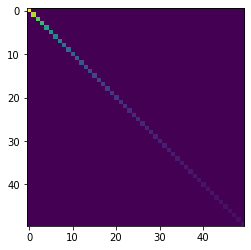

In [212]:
plt.imshow(S_ij)

### Shot noise

In [213]:
shot_noise_variance = np.diag(Abundance_simps.flatten())

In [214]:
covariance = sample_covariance + shot_noise_variance

In [215]:
sample_covariance

array([[3.17144350e+00, 3.03264452e+00, 2.90187414e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.03264452e+00, 2.89992010e+00, 2.77487293e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.90187414e+00, 2.77487293e+00, 2.65521789e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.83110839e-04, 1.53532344e-04, 1.28118689e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.53532344e-04, 1.28731760e-04, 1.07423256e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.28118689e-04, 1.07423256e-04, 8.96418723e-05]])

## data

In [216]:
x_th_SV = np.random.multivariate_normal(mean = Abundance_simps.flatten(),
                                       cov = sample_covariance)

In [217]:
N_obs = np.random.poisson(lam=x_th_SV)

In [218]:
N_obs_matrix = N_obs.reshape([len(Z_bin),len(logMass_bin)])

In [219]:
delta_map = x_th_SV

## Likelihood

In [220]:
%load_ext autoreload
%autoreload 2
import CL_COUNT_class_likelihood as lnL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
Likelihood = lnL.Likelihood()

### Binned Poisson/Gaussian Mixture (diagonal covariance matrix)

$L = \prod_i^N\int dx_i \mathcal{P}(\widehat{N}_i| x_i)\times \mathcal{G}(x_i|\mu_i, \sigma_{SV,i}^2)$

In [222]:
lnL_Binned_MPG_diagonal = Likelihood.lnLikelihood_Binned_MPG_diagonal(Abundance_simps.flatten(), N_obs, sample_covariance.diagonal())
print(Likelihood.lnL_Binned_MPG_diagonal)

-6997.645008864715


### Binned Poisson/Gaussian Mixture (estimator, full covariance matrix)

$L = \int d\vec{x} \prod_i^N\mathcal{P}(\widehat{N}_i| x_i)\times \mathcal{G}(\vec{x}|\vec{\mu}, \Sigma_{SV}) \rightarrow \widehat{L} = \frac{1}{N_{sample}} \sum_{j= 1}^{N_{sample}}\prod_i^N\mathcal{P}(\widehat{N}_i| x_{i,j}) $

where $x_{i,j}$ is the $j-$th random realisation of the $i-$th cluster abundance bin, following the Gaussian distribution $\mathcal{G}(.|\vec{\mu}, \Sigma_{SV})$ 

In [223]:
lnL_Binned_MPG_delta = Likelihood.lnLikelihood_Binned_MPG_delta(Abundance_simps.flatten(), N_obs, sample_covariance)
print(Likelihood.lnL_Binned_MPG_delta)

-6996.8444366861095


### Binned Poisson/Gaussian Mixture (approximation)

In [224]:
lnL_Binned_MPG_approx = Likelihood.lnLikelihood_Binned_MPG_approx(Abundance_simps.flatten(), N_obs, sample_covariance)
print(Likelihood.lnL_Binned_MPG_approx)

-inf


/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_COUNT_class_likelihood.py:181: RuntimeWarning: divide by zero encountered in log
  Poisson[i] = self.poissonian(N_obs[i], mu_)


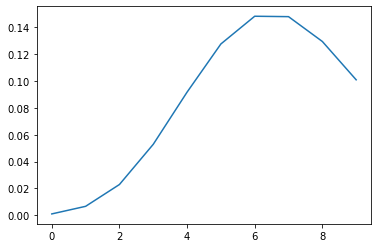

In [225]:
N = np.arange(10)
P = np.zeros(len(N))
for i,n in enumerate(N):
    Likelihood.lnLikelihood_Binned_MPG_approx(np.array([7]),np.array([n]), np.array([.1]))
    P[i] = np.exp(Likelihood.lnL_Binned_MPG_approx)
plt.plot(N, P)

In [226]:
%load_ext autoreload
%autoreload 2
import CL_COUNT_class_likelihood as lnL
Likelihood = lnL.Likelihood()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [227]:
Likelihood.lnLikelihood_Binned_MPG_Block_Diagonal(Abundance_simps, N_obs_matrix, Binned_halo_bias, S_ij.diagonal(), method = 'exact')
print(Likelihood.lnL_Binned_MPG_Block_Diagonal)

-6992.306521680472


In [228]:
from scipy.stats import poisson
from scipy.stats import multivariate_normal
from scipy.integrate import quad,simps, dblquad

In [241]:
def lnLikelihood_Binned_MPG_Block_Diagonal(N_th_matrix, N_obs_matrix, Halo_bias, S_ii):
        
        n_z_bin, n_m_bin = N_th_matrix.shape
        n = 20
        def _integrand_(dx, n_th, n_obs, hbias, S_ii): 
            rv = poisson(n_th*(1 + hbias*dx))
            return np.prod(rv.pmf(n_obs)) * multivariate_normal.pdf(dx, mean=0, cov=S_ii)
        mvp = np.zeros(n_z_bin)
        for i in range(n_z_bin):
            n_obs, n_th = N_obs_matrix[i,:], N_th_matrix[i,:]
            hbias = Halo_bias[i,:]
            
            min_border = max(-n*np.sqrt(S_ii[i]), max(-1/hbias))
            max_border = (n+1)*np.sqrt(S_ii[i])
            x_test = np.linspace(min_border, max_border, 100)
            tab_integrand = np.zeros(len(x_test))
            for j, x_ in enumerate(x_test):
                tab_integrand[j] = _integrand_(x_, n_th, n_obs, hbias, S_ii[i])
            plt.plot(x_test, tab_integrand)
            plt.yscale('log')
            res, err = quad(_integrand_, min_border, max_border,
                           epsabs=1.49e-08, epsrel=1.49e-08,
                           args = (n_th, n_obs, hbias, S_ii[i])) 
            mvp[i] = res
          
        return  np.sum(np.log(mvp))

-6992.30641874465

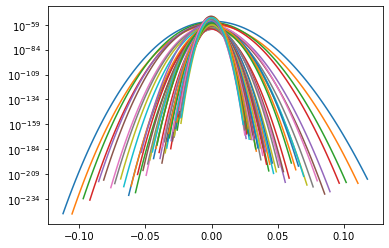

In [242]:
lnLikelihood_Binned_MPG_Block_Diagonal(Abundance_simps, N_obs_matrix, Binned_halo_bias, S_ij.diagonal())